# api

> APIのページです。

In [2163]:
#| default_exp api

In [2164]:
#| hide
from nbdev.showdoc import *


In [2165]:
#| export
import numpy as np
from PIL import Image, ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True
import json
import os
from pylsd.lsd import lsd
import cv2
from scipy.signal import argrelmin, argrelmax
from collections import Counter
from statistics import mode
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import japanize_matplotlib

In [2166]:
#| export
class Ruler:
    def __init__(self, path, tmp_dir = "tmp", isHorizontal = True):
        self.input_path = path

        img = cv2.imread(self.input_path)
        if isHorizontal:
            img_h, img_w, z = img.shape 
        else:
            img_w, img_h, z = img.shape
        self.img_w = img_w
        self.img_h = img_h

        self.tmp_dir = tmp_dir
        self.isHorizontal = isHorizontal
        os.makedirs(tmp_dir, exist_ok=True)
        pass

    def calc2(self, debug=False):
        '''
        メイン処理
        '''
        rotate_path = self.tmp_dir + "/rotate.jpg"
        Ruler.rotate(self.input_path, rotate_path)

        blur_path = self.tmp_dir + "/blur.jpg"
        Ruler.blur(rotate_path, blur_path)
        
        ad_path = self.tmp_dir + "/ad.jpg"
        Ruler.ad_s(blur_path, ad_path)

        otsu_path = ad_path
        
        saisen_path = self.tmp_dir + "/skelton.jpg"
        Ruler.skelton_s(otsu_path, saisen_path)

        lsd_path = self.tmp_dir + "/lsd.jpg"
        Ruler.hlsd_s(saisen_path, saisen_path, lsd_path)

        x_index, x_values, y_values = Ruler.get_line(saisen_path)

        line_path = self.tmp_dir + "/line.jpg"
        Ruler.write_line(saisen_path, line_path, x_index)

        row_path = self.tmp_dir + "/row.jpg"
        Ruler.save_row_img(saisen_path, row_path, x_index)

        

        freq, ws = Ruler.get_ws(row_path)

        # ここも

        x_values, y_values = Ruler.show_freq(freq, xlabel="点の間隔", ylabel="頻度")

        pixelPerMM = Ruler.get_pixel_per_mm(ws) #  + 2

        # ラスト

        result_path = self.tmp_dir + "/result.jpg"
        Ruler.write_lines(rotate_path, result_path, pixelPerMM)

        self.cm_path = result_path

        self.pixelPerMM = pixelPerMM

    @staticmethod
    def get_line(path):
        sums = Ruler.get_up_down(path)
        x_values, y_values = Ruler.show_freq(sums)

        y_max = max(y_values)
        x_index = y_values.index(y_max)
        # print("x", "y", x_index, y_max)

        return x_index, x_values, y_values

    # 要検討
    @staticmethod
    def get_ws(path):

        img = cv2.imread(path)

        blacks = []

        h, w = img.shape[:2]

        for x in range(w):
            v = img[0][x][0]
            if v >  128:
                pass
            else:
                blacks.append(x)

        freq = {}

        ws = []

        for i in range(len(blacks) - 1):
            w = blacks[i + 1] - blacks[i]

            if w not in freq:
                freq[w] = 0

            freq[w] += 1

            ws.append(w)

        return freq, ws

    # 1より大きい値
    def get_mode_values(values, thres = 1):
        values = [i for i in values if i > thres]
        c = Counter(values)
        values = c.most_common(1)[0]
        return list(values)

    @staticmethod
    def get_mode_value(ws):

        mode_values = Ruler.get_mode_values(ws)
        avg = np.mean(ws)

        d = 10000

        for mode_value in mode_values:
            if abs(mode_value - avg) < d:
                d = abs(mode_value - avg)
                mode_value_ = mode_value

        return mode_value_

    @staticmethod
    def get_pixel_per_mm(ws):


        return Ruler.get_mode_value(ws)

    @staticmethod
    def write_lines(path, output_path, pixelPerMM):

        img = cv2.imread(path)
        h, w = img.shape[:2]
        red_line_img = img.copy()

        i = 0

        while 1:

            x = pixelPerMM * i

            if x > w:
                break
            
            if i % 10 == 0:
                color = (0, 0, 255)
                size = 3
            else:
                color = (255, 0, 0)
                size = 1
            
            red_line_img = cv2.line(red_line_img, (x,0), (x,h), color, size)

            i += 1


        cv2.imwrite(output_path, red_line_img)

    @staticmethod
    def calc(path, task_id = "", tmp_dir = "tmp", isHorizontal = True, debug=False):
        if task_id != "":
            tmp_dir = tmp_dir + "/" + str(task_id)
        ins = Ruler(path, tmp_dir = tmp_dir, isHorizontal = isHorizontal)
        ins.calc2(debug=debug)

        return {
            "path": ins.cm_path,
            "width": ins.img_w if ins.isHorizontal else ins.img_h,
            "height": ins.img_h if ins.isHorizontal else ins.img_w,
            "pixelPerMM": ins.pixelPerMM,
        }

    @staticmethod
    def rotate(input_path, output_path):
        # Load image, grayscale, Otsu's threshold 
        image = cv2.imread(input_path)
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        
        gray = 255 - gray
        
        thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]

        # Compute rotated bounding box
        coords = np.column_stack(np.where(thresh > 0))
        angle = cv2.minAreaRect(coords)[-1]

        # 要検討
        if angle > 45:

            if angle < -45:
                angle = -(90 + angle)
            else:
                angle = -angle

            angle = 90 + angle

        # Rotate image to deskew
        (h, w) = image.shape[:2]
        center = (w // 2, h // 2)
        M = cv2.getRotationMatrix2D(center, angle, 1.0)
        rotated = cv2.warpAffine(image, M, (w, h), flags=cv2.INTER_CUBIC, borderMode=cv2.BORDER_REPLICATE)

        cv2.imwrite(output_path, rotated)

    def blur(input_path, output_path):
        img = cv2.imread(input_path)
        blur = cv2.blur(img, (3, 3))
        cv2.imwrite(output_path, blur)

    def canny_s(input_path, output_path):
        '''
        Cannyエッジ検出
        '''
        img = cv2.imread(input_path)
        img_canny = cv2.Canny(img, 100, 200)

        
        cv2.imwrite(output_path, img_canny)
        

    def canny(self):
        '''
        Cannyエッジ検出
        '''
        img = cv2.imread(self.input_path)
        img_canny = cv2.Canny(img, 100, 200)

        output_path = self.tmp_dir + "/canny.jpg"
        cv2.imwrite(output_path, img_canny)
        self.canny_path = output_path

    @staticmethod
    def otsu_s(input_path, output_path):
        '''
        大津の二値化
        '''

        img = cv2.imread(input_path)
        gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

        ret2, img_otsu = cv2.threshold(gray, 0, 255, cv2.THRESH_OTSU)

        img_otsu = 255- img_otsu

        cv2.imwrite(output_path, img_otsu)

    @staticmethod
    def ad_s(input_path, output_path):
        '''
        adaptiveThreshold
        '''

        img = cv2.imread(input_path)
        gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

        img_otsu = cv2.adaptiveThreshold(
        gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
        cv2.THRESH_BINARY, 51, 20)

        img_otsu = 255- img_otsu

        cv2.imwrite(output_path, img_otsu)
    
    def otsu(self):
        '''
        大津の二値化
        '''

        input_path = self.canny_path
        output_path = self.tmp_dir + "/otsu.jpg"
        self.otsu_path = output_path

        Ruler.otsu_s(input_path, output_path)

        '''
        img = cv2.imread(self.canny_path)
        gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

        ret2, img_otsu = cv2.threshold(gray, 0, 255, cv2.THRESH_OTSU)

        # cv2.imwrite(output_path, img_otsu)

        otsu_path = self.tmp_dir + "/otsu.jpg"
        cv2.imwrite(otsu_path, img_otsu)
        self.otsu_path = otsu_path
        '''

    @staticmethod
    def skelton_s(input_path, output_path, reverse = False, basic = True):

        img = cv2.imread(input_path)
        gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

        # 二値画像反転
        # if reverse:
        if not basic:
            gray = cv2.bitwise_not(gray)
            # pass
        # _, gray = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
        

        # skelton = cv2.ximgproc.thinning(gray, thinningType=cv2.ximgproc.THINNING_ZHANGSUEN)
        skelton = cv2.ximgproc.thinning(gray, thinningType=cv2.ximgproc.THINNING_GUOHALL)

        if reverse or True:
            skelton = 255- skelton
            # pass

        cv2.imwrite(output_path, skelton)

        

    def skelton(self):
        '''
        細線化
        '''
        input_path = self.otsu_path
        output_path = self.tmp_dir + "/skelton.jpg"
        self.skelton_path = output_path

        Ruler.skelton_s(input_path, output_path)

    @staticmethod
    def hlsd_s(input_path, color_path, output_path, isHorizontal = True):
        img = cv2.imread(input_path)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        w = img.shape[1] if isHorizontal else img.shape[0]
        h = img.shape[0] if isHorizontal else img.shape[1]

        lines = lsd(gray)

        # 保存

        img_color = cv2.imread(color_path)

        for line in lines:
            x1, y1, x2, y2 = map(int,line[:4])
            if (x2-x1)**2 + (y2-y1)**2 > 10000:
                img_color = cv2.line(img_color, (x1,y1), (x2,y2), (0,0,255), 1)
            else:
                img_color = cv2.line(img_color, (x1,y1), (x2,y2), (0,255,255), 1)

       
        cv2.imwrite(output_path, img_color)

        return lines

    

    def hlsd(self, isHorizontal = True):
        '''
        LSDを使って線を抽出
        '''

        img = cv2.imread(self.skelton_path)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        w = img.shape[1] if isHorizontal else img.shape[0]
        h = img.shape[0] if isHorizontal else img.shape[1]

        lines = lsd(gray)

        # 保存

        img_color = cv2.imread(self.input_path)

        for line in lines:
            x1, y1, x2, y2 = map(int,line[:4])
            img_color = cv2.line(img_color, (x1,y1), (x2,y2), (0,0,255), 1)

        output_path = self.tmp_dir + "/hlsd.jpg"
        cv2.imwrite(output_path, img_color)
        self.hlsd_path = output_path

        x = []
        y = []

        for i in range(w):
            x.append(i)
            y.append(0)

        for i in range(lines.shape[0]):
            if isHorizontal:
                dx = int((int(lines[i, 0]) +  int(lines[i, 2])) / 2)
                dy = int(lines[i, 3]) - int(lines[i, 1])
            else:
                dx = int((int(lines[i, 1]) +  int(lines[i, 3])) / 2)
                dy = int(lines[i, 2]) - int(lines[i, 0])
            y[dx] = dy  

        x = np.array(x)
        y = np.array(y)

        arg_r_min,arg_r_max=argrelmin(y),argrelmax(y)

        self.x = x
        self.y = y

        self.arg_r_min = arg_r_min
        self.arg_r_max = arg_r_max

    def show(self):
        '''
        グラフを表示
        '''
        x, y = self.x, self.y
        arg_r_min, arg_r_max = self.arg_r_min, self.arg_r_max

        fig, ax = plt.subplots(dpi=130)
        ax.plot(x,y,"C2-")
        ax.plot(x[arg_r_min[0]],y[arg_r_min[0]],"ro",label="argrelmin")
        ax.plot(x[arg_r_max[0]],y[arg_r_max[0]],"mo",label="argrelmax")
        plt.legend()
        plt.show()

    @staticmethod
    def show_freq(freq, title = None, xlabel = None, ylabel = None):
        x_values = []
        y_values = []

        x_max = max(freq.keys())

        for i in range(x_max):
            x_values.append(i)
            y_values.append(freq.get(i, 0))

        '''
        plt.plot(x_values, y_values)
        if title:
            plt.title(title)

        if xlabel:
            plt.xlabel(xlabel)

        if ylabel:
            plt.ylabel(ylabel)
        '''

        return x_values, y_values

    @staticmethod
    def show_xy(x_values, y_values, title = None, xlabel = None, ylabel = None):
        plt.plot(x_values, y_values)
        if title:
            plt.title(title)

        if xlabel:
            plt.xlabel(xlabel)

        if ylabel:
            plt.ylabel(ylabel)

    @staticmethod
    def write_line(path, output_path, i, isHorizontal = True):
        img = cv2.imread(path)
        h, w = img.shape[:2]

        img_copy = img.copy()

        if isHorizontal:
            for x in range(w):
                img_copy = cv2.line(img_copy, (x, i), (x, i + 1), (0,0,255), 1)
        else:
            for y in range(h):
                img_copy = cv2.line(img_copy, (i, y), (i + 1, y), (0,0,255), 1)

        cv2.imwrite(output_path, img_copy)


    @staticmethod
    def get_up_down(path):
        img = cv2.imread(path)

        h, w, c = img.shape

        x_values = []
        y_values = []

        sums = {}

        isHorizontal = True

        axis_1 = h if isHorizontal else w
        axis_2 = w if isHorizontal else h

        for i in range(axis_1):

            if i not in sums:
                sums[i] = 0

            sum = 0
            previous_value = -1
            for j in range(axis_2):

                if isHorizontal:
                    pixel_value = img[i][j][0]
                else:
                    pixel_value = img[j][i][0]

                if pixel_value > 128:
                    value = 0
                else:
                    value = 1

                if previous_value != value:
                    sum += value

                previous_value = value

            sums[i] += sum

        return sums

    @staticmethod
    def save_row_img(path, output_path, i, isHorizontal = True):
        img = cv2.imread(path)

        h, w, c = img.shape

        if isHorizontal:
            dst = img[i:i+1, 0:w]
        else:
            dst = img[0:h, i:i+1]

        cv2.imwrite(output_path, dst)

    def get_info(self):
        '''
        1pxあたりの長さを取得
        '''
        img_w = self.img_w
        img_h = self.img_h
        isHorizontal = self.isHorizontal
        img = cv2.imread(self.input_path)

        x = self.x
        arg_r_max = self.arg_r_max

        x0 = 0

        map2 = {}

        l = []

        for x1 in x[arg_r_max[0]]:

            d = x1 - x0
            if d not in map2:
                map2[d] = 0

            x0 = x1

            l.append(d)

        c = Counter(l)
        values = c.most_common(1)[0]

        values = list(values)
        
        pixelPerMM = min(values)

        mode_value = pixelPerMM * 10

        flg = True

        x_s = 0

        while flg:
            if isHorizontal:
                red_line_img = cv2.line(img, (x_s,0), (x_s,img_h), (255,0,0), 3)
            else:
                red_line_img = cv2.line(img, (0, x_s), (img_w, x_s), (255,0,0), 3)

            x_s += mode_value

            if x_s > img_w:
                flg = False

        output_path = self.tmp_dir + "/1cm.jpg"
        cv2.imwrite(output_path, red_line_img)
        self.cm_path = output_path

        self.pixelPerMM = pixelPerMM


In [2167]:
def show_img(path):
    plt.imshow(mpimg.imread(path),cmap="gray")

In [2168]:
show_doc(Ruler)

---

### Ruler

>      Ruler (path, tmp_dir='tmp', isHorizontal=True)

Initialize self.  See help(type(self)) for accurate signature.

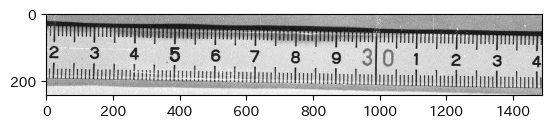

In [2169]:
# path = "data/612110.jpeg"
# path = "data/IiReU.jpeg"
# path = "data/0e067eb07d7b435ce8b1074513efd41a.jpeg"
# path = "data/simple.jpeg"
# path = "data/ndl.png"
path = "data/hi.png"
# path = "rotated.jpg"
# path = "data/hi2.png"
# path = "data/hi3.png"
ins = Ruler(path)
plt.imshow(mpimg.imread(path),cmap="gray")


## 傾き補正

In [2170]:
show_doc(Ruler.rotate)

---

### Ruler.rotate

>      Ruler.rotate (input_path, output_path)

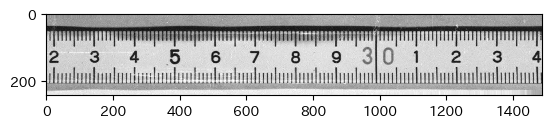

In [2171]:
rotate_path = "tmp/rotate.jpg"
Ruler.rotate(path, rotate_path)
show_img(rotate_path)

## 平滑か

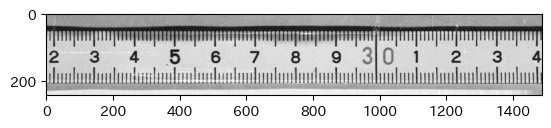

In [2172]:
blur_path = "tmp/blur.jpg"
Ruler.blur(rotate_path, blur_path)
show_img(blur_path)

## 二値化

In [2173]:
show_doc(Ruler.ad_s)

---

### Ruler.ad_s

>      Ruler.ad_s (input_path, output_path)

adaptiveThreshold

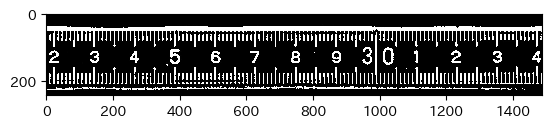

In [2174]:
otsu_path = "tmp/otsu.jpg"
Ruler.ad_s(blur_path, otsu_path)
show_img(otsu_path)

## 細線化

In [2175]:
show_doc(Ruler.skelton_s)

---

### Ruler.skelton_s

>      Ruler.skelton_s (input_path, output_path, reverse=False, basic=True)

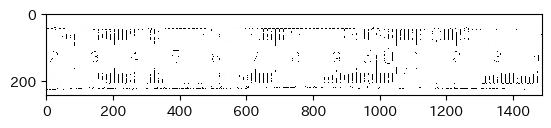

In [2176]:
saisen_path = "tmp/saisen.jpg"
Ruler.skelton_s(otsu_path, saisen_path)
show_img(saisen_path)

## 変化がもっとも多いy軸の値を取得する

In [2177]:
show_doc(Ruler.get_line)

---

### Ruler.get_line

>      Ruler.get_line (path)

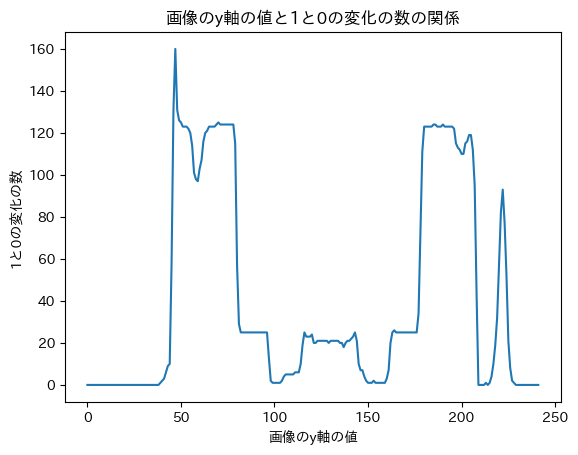

In [2178]:
x_index, x_values, y_values = Ruler.get_line(saisen_path)
Ruler.show_xy(x_values, y_values, title="画像のy軸の値と1と0の変化の数の関係", xlabel="画像のy軸の値", ylabel="1と0の変化の数")

## 横線をひく

In [2179]:
show_doc(Ruler.write_line)

---

### Ruler.write_line

>      Ruler.write_line (path, output_path, i, isHorizontal=True)

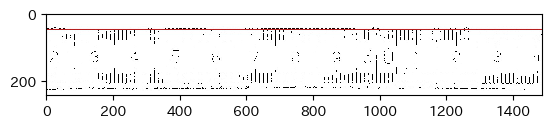

In [2180]:
line_path = "tmp/line.jpg"
Ruler.write_line(saisen_path, line_path, x_index)
show_img(line_path)

In [2181]:
show_doc(Ruler.save_row_img)

---

### Ruler.save_row_img

>      Ruler.save_row_img (path, output_path, i, isHorizontal=True)

In [2182]:
row_path = "tmp/row.jpg"
Ruler.save_row_img(saisen_path, row_path, x_index)
# show_img(row_path)

## 行画像から間隔を取得する

In [2183]:
show_doc(Ruler.get_ws)

---

### Ruler.get_ws

>      Ruler.get_ws (path)

In [2184]:
freq, ws = Ruler.get_ws(row_path)

In [2185]:
x_values, y_values = Ruler.show_freq(freq)

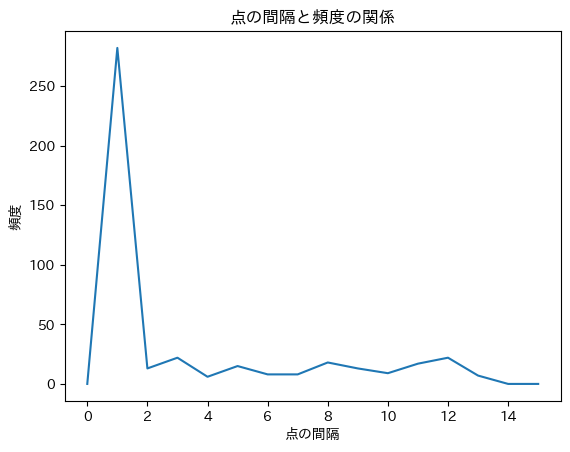

In [2186]:
Ruler.show_xy(x_values, y_values, title="点の間隔と頻度の関係", xlabel="点の間隔", ylabel="頻度")

In [2187]:
show_doc(Ruler.get_pixel_per_mm)

---

### Ruler.get_pixel_per_mm

>      Ruler.get_pixel_per_mm (ws)

In [2188]:
pixelPerMM = Ruler.get_pixel_per_mm(ws)

print("pixelPerMM", pixelPerMM)

pixelPerMM 12


In [2189]:
## 結果を表示

In [2190]:
show_doc(Ruler.write_lines)

---

### Ruler.write_lines

>      Ruler.write_lines (path, output_path, pixelPerMM)

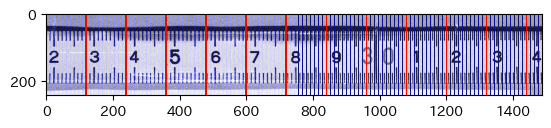

In [2191]:
result_path = "tmp/result.jpg"
Ruler.write_lines(rotate_path, result_path, pixelPerMM)
show_img(result_path)

In [2192]:
#| hide
import nbdev; nbdev.nbdev_export()